In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import seaborn as sns

sys.path.append('../lib')
from hier_group import unpack_hier_names
from local_paths import mplstyle_path, preproc_dir, analysis_dir, database_dir

In [2]:
plt.style.use(mplstyle_path)

# Parameters 

In [3]:
# Session
sess_name = 'Pa200515'; unit_name = '4a'

# plot parameters
pal = palettable.cartocolors.qualitative.Bold_10.mpl_colors
max_scatter = 1000

# unit selection
unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'

# Image for illustration
example_image_name = 'a80e4aaa9bc840d1c96607e2e29e3cd5.jpg'

# Load data

In [4]:
proc_dir = Path(preproc_dir).expanduser()
rsc_dir = Path(analysis_dir).expanduser() / 'self_consistency'
rsc_nd_dir = Path(analysis_dir).expanduser() / 'self_consistency_no_decorr'

In [5]:
proc_path = proc_dir / (sess_name + '-proc.h5')
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
    im_size_dva = f['stimulus/size_dva'][()]
    sacc_sel = f['saccade_selection/fixation_indices'][()]
    fix_sel = sacc_sel[1]
    unit_names = f['unit_selection/simple'][()].astype(str)

m = pd.Series(unit_names).isin(pd.read_csv(unit_sel_path).set_index('Session').loc[[sess_name]].values.ravel())
unit_names = unit_names[m]

In [6]:
rasters_path = Path(proc_dir) / (sess_name + '-rasters.nwb')
with h5.File(rasters_path, 'r') as f:
    all_unit_names = list(f['processing/ecephys/unit_names/unit_name'][()].astype(str))    
    unit_sel = np.array([v in unit_names for v in all_unit_names])
    unit_sel = np.nonzero(unit_sel)[0]
    rasters = f['processing/ecephys/rasters/data'][()]
    rasters = rasters[:,unit_sel]

In [7]:
results_path = rsc_dir / (sess_name + '.h5')
results_nd_path = rsc_nd_dir / (sess_name + '.h5')
with h5.File(results_nd_path, 'r') as f:
    group = f['self_consistency/return_pairs']
    curr_return_pairs = fix_sel[group['current'][()]]
    prev_return_pairs = fix_sel[group['previous'][()]]
    
bycond_rsc = {}
for cond0, path in (('decorr', results_path), ('no_decorr', results_nd_path)):
    with h5.File(path, 'r') as f:
        rsc_ts = f['self_consistency/current/time'][()]
        unit_names_ = f['self_consistency/current/unit'][()].astype(str)
        unit_names_ = unpack_hier_names(unit_names_)
        m = unit_names_[:,0] == 'Unit'
        m &= pd.Series(unit_names_[:,1]).isin(unit_names)
        
        for cond1 in ('current', 'previous'):
            group = f['self_consistency'][cond1]
            bycond_rsc[(cond0, cond1)] = group['sample'][()][:,m]

# Illustrate return-fixation self-consistency for one time bin

In [8]:
bycond_resps_2pt = {}
for cond, pairs in (('current', curr_return_pairs), ('previous', prev_return_pairs)):
    resps_2pt = np.empty((2, len(pairs), 2, rasters.shape[-1]))
    ts = np.round(fix_df['Time'].values).astype(int)
    for i, pair in enumerate(pairs):
        for j, idx in enumerate(pair):
            t = ts[idx]
            resps_2pt[0,i,j] = rasters[t-200:t].mean(0)
            resps_2pt[1,i,j] = rasters[t:t+200].mean(0)
    bycond_resps_2pt[cond] = resps_2pt * 1e3

In [9]:
iunit = list(unit_names).index(unit_name)
rg = np.random.RandomState(random_seed)

unit_resps_2pt = bycond_resps_2pt['current'][...,iunit]
unit_prev_resps_2pt = bycond_resps_2pt['previous'][...,iunit]
unit_resps_2pt_jittered = unit_resps_2pt + rg.normal(0,5,size=unit_resps_2pt.shape)
unit_prev_resps_2pt_jittered = unit_prev_resps_2pt + rg.normal(0,5,size=unit_prev_resps_2pt.shape)

selecting 1000 from 18976 for plotting
selecting 1000 from 14887 for plotting


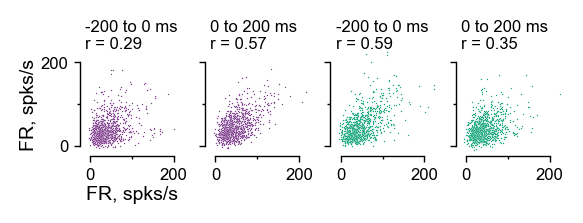

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(3.1, .75), sharex=True, sharey=True)

for ii, (unit_resps_, unit_resps_raw, color) in enumerate((
        (unit_resps_2pt_jittered, unit_resps_2pt, pal[0]),
        (unit_prev_resps_2pt_jittered, unit_prev_resps_2pt, pal[1]))):
    n = unit_resps_.shape[1]
    if n > max_scatter:
        sel = np.unique(np.round(np.linspace(0, n-1, max_scatter).astype(int)))
        print(f'selecting {len(sel)} from {n} for plotting')
    else:
        sel = slice(None)
    
    kws = dict(s=0.25, color=color)
    vals = []
    for i in range(2):
        r_all = unit_resps_raw[i]  # shape (n, 2)
        corr = np.corrcoef(*r_all.T)[0,1]

        ax = axs[ii*2 + i]
        r_sel = unit_resps_[i][sel]
        sns.scatterplot(x=r_sel[:,0], y=r_sel[:,1], ax=ax, **kws)
        vals.append(r_sel)

        t = ('-200 to 0 ms', '0 to 200 ms')[i] + f'\nr = {corr:.2f}'
        ax.text(.05, 1, t, ha='left', va='bottom', transform=ax.transAxes, fontsize=6)

    vals = np.concatenate(vals)
    tk_res = [-1, 25, 50, 100, 200]
    itk = min(np.digitize(vals.max(),tk_res)-1, len(tk_res)-1)
    mtk_res = tk_res[max(1, itk-1)]
    tk_res = tk_res[itk]
    tks = np.arange(0, (np.floor(vals.max()/tk_res)+.1)*tk_res, tk_res)
    mtks = np.arange(0, (np.floor(tks.max()/mtk_res)+.1)*mtk_res, mtk_res)
    lims = mtks[0]-mtk_res/4, mtks[-1]+mtk_res/4
    for ax in axs:
        ax.set_xlim(lims)
        ax.set_xticks(tks)
        ax.set_xticks(mtks, minor=True)
        ax.spines['bottom'].set_bounds(mtks[0], mtks[-1])

        ax.set_ylim(lims)
        ax.set_yticks(tks)
        ax.set_yticks(mtks, minor=True)
        ax.spines['left'].set_bounds(mtks[0], mtks[-1])

        ax.set_aspect('equal')

    axs[0].set_xlabel('FR, spks/s')
    axs[0].set_ylabel('FR, spks/s')

plt.savefig('plots/fig3e.png')

In [11]:
rsc_2pt = np.empty((2, 2, unit_names.size), dtype=np.float32)

for ii, resps_raw in enumerate((bycond_resps_2pt['current'], bycond_resps_2pt['previous'])):
    for i in range(2):
        r_all = resps_raw[i,:,]  # shape (n, 2, nu)
        for j in range(unit_names.size):
            rsc_2pt[ii,i,j] = np.corrcoef(*r_all[...,j].T)[0,1]

rsc_curr_2pt, rsc_prev_2pt = rsc_2pt

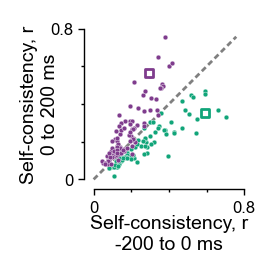

In [12]:
fig = plt.figure(figsize=(1.1,1.1))
ax = plt.gca()

sns.scatterplot(x=rsc_prev_2pt[0], y=rsc_prev_2pt[1], color=pal[1], s=3, legend=False)
sns.scatterplot(x=rsc_curr_2pt[0], y=rsc_curr_2pt[1], color=pal[0], s=3, legend=False)
ax.scatter(*rsc_prev_2pt[:,iunit], ec=pal[1], fc='w', marker='s', s=10)
ax.scatter(*rsc_curr_2pt[:,iunit], ec=pal[0], fc='w', marker='s', s=10)

vals = np.array([rsc_prev_2pt, rsc_curr_2pt])
vmax = np.nanmax(vals)
ax.plot([0, vmax], [0, vmax], color='gray', ls='--', zorder=-1)

tks = [0,.8]
mtks = np.arange(0, .81, .2)
bounds = mtks[0], mtks[-1]

ax.set_xlim(-.05,tks[1]+.05)
ax.set_xticks(tks, map(str, tks))
ax.set_xticks(mtks, minor=True)
ax.spines['bottom'].set_bounds(bounds)
ax.set_xlabel('Self-consistency, r\n-200 to 0 ms')

ax.set_ylim(-.05,tks[1]+.05)
ax.set_yticks(tks, map(str, tks))
ax.set_yticks(mtks, minor=True)
ax.spines['left'].set_bounds(bounds)
ax.set_ylabel('Self-consistency, r\n0 to 200 ms')

ax.set_aspect('equal')

for i, axis in enumerate((ax.xaxis, ax.yaxis)):
    xy = (-.15, np.mean(bounds))
    tfs = (ax.transAxes, ax.transData)
    tfm = mpl.transforms.blended_transform_factory(*tfs[::(i*2-1)])
    axis.set_label_coords(*xy[::(i*2-1)], transform=tfm)

plt.savefig('plots/fig3f.png')

# Illustrate self-consistency time courses

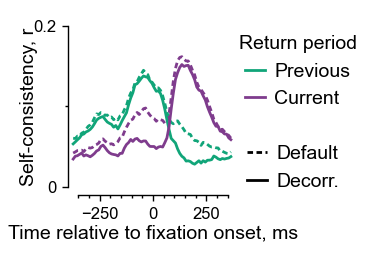

In [13]:
fig = plt.figure(figsize=(1.1, 1.1))
ax = plt.gca()

for i, (cond0, ls) in enumerate((
        ('no_decorr', '--'),
        ('decorr', '-'))):
    for j, (cond1, color) in enumerate(zip(
            ('previous', 'current'),
            (pal[1], pal[0]))):
        label = cond1.capitalize() if i else None
        m = np.mean(bycond_rsc[(cond0,cond1)], axis=1)
        ax.plot(rsc_ts, m, color=color, ls=ls, label=label)


leg1 = ax.legend(loc='upper left', bbox_to_anchor=(.9,1.05), title='Return period')
leg2 = [
    mpl.lines.Line2D([0], [0], color='k', ls=ls, label=label)
    for ls, label in (('--', 'Default'), ('-', 'Decorr.'))]
leg2 = ax.legend(handles=leg2, loc='upper left', bbox_to_anchor=(.95,.4))
ax.add_artist(leg1)

xlim = (-400, 400)
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
ax.set_xlim(xlim)
ax.set_xticks(xtks)
ax.set_xticks(xmtks, minor=True)
ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())

ybound = (0, .2)
dy = (ybound[1] - ybound[0]) / 20
ylim = [ybound[0]-dy, ybound[0]+dy]
ymtks = np.arange(*ybound,.1)
ax.set_ylim(ylim)
ax.set_yticks(ybound, list(map(str, ybound)))
ax.set_yticks(ymtks, minor=True)
ax.spines['left'].set_bounds(ybound)

ax.set_xlabel('Time relative to fixation onset, ms')
ax.set_ylabel('Self-consistency, r')
tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-.175, np.mean(ybound), transform=tform)

plt.savefig('plots/fig3g.png')